## Data visualization and structure-activity classification of chemical libraries with Generative Topographic Mapping (GTM)

<h3>Summary</h3>
<p style="text-align:justify">The following notebook illustrates a step-by-step procedure of data visualization and structure-activity profiling of libraries of compounds, tested on viral proteins. A set of 10k compounds was carefully examined in terms of their activity measurements against different protein targets. The largest and the most uniform subset consisted of 4k molecules and their reported IC50 values. Based on the range of IC50 values, this subset was partitioned, into 5 classes, from the most inactive (--), to the most active (++). The molecules were encoded in terms of ISIDA Fragment descriptors and projected onto the latent space to visualize, using the GTM technique. To assess the power of the GTM method at classifying new, unseen compounds, the subset of 4k compounds was split into a training and test set. A GTM classifier, fitted on the training set, was used to predict the labels of the test set. The results show that GTM performed fairly well at predicting the acitivities of compounds in the test set.</p>

# Step 1: Loading the molecules into Jupyter Notebook

<p style="text-align:justify">We will use the PandasTools module of the rdkit library [1] to read the 10k molecules from the SDF file into a pandas DataFrame object.</p>

In [1]:
# Python imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import PandasTools

In [2]:
import ipywidgets as widgets

In [3]:
sdfile = PandasTools.LoadSDF("LC_Antiviral_Library_2D_Similarity.sdf",
                            smilesName="SMILES",
                            molColName="Molecule",
                            includeFingerprints=True)

In [4]:
print(sdfile.columns)

Index(['IDNUMBER', 'fromRegid', 'Similarity', 'Target_name', 'Activity_type',
       'Activity_value', 'Activity_units', 'Target_organism', 'Target_type',
       'Chemical_Name', 'PriceCoeff', 'CAS', 'Description', 'clogP', 'MW',
       'Acceptor', 'Donor', 'RotBonds', 'FSP3', 'TPSA', 'HAC', 'Collection',
       'ID', 'SMILES', 'Molecule', 'LCTNUMBER'],
      dtype='object')


#### Step 2: Exploratory data analysis - activity measurements

<p style="text-align:justify">Since we are interested in the activity profiles of compounds irrespective of the targets they were tested on, we will sort the compounds by the "Activity_type" and "Activity_units" columns. Upon inspecting the entries of the corresponding columns, we can see there are several different activity type measurements, with a wide variety of different reported units. It is reasonable to group compounds by different activity types first, followed by activity units.</p>

In [5]:
# The list of reported activity types
sdfile["Activity_type"].unique()

array(['EC50', 'EC90', 'Activity', 'Kd', 'IC50', 'CC50', 'ED50',
       'Inhibition', 'MIC50', 'ID50', 'IC25', 'Ki', 'Inhibition zone',
       'MIC', 'TC50', 'MTL', 'Viability', 'ED99', 'IC95', 'PDD50', 'MED',
       'PD50', 'Survival', 'CyD50'], dtype=object)

In [6]:
# The list of reported units of measurement
sdfile["Activity_units"].unique()

array(['ug.mL-1', 'uM', '%', 'nM', 'ug ml-1', 'ug', 'umol/L', 'mM', 'pg'],
      dtype=object)

In [7]:
# Number of measurements per activity units per activity type
sdfile.groupby(["Activity_type","Activity_units"]).count()

IDNUMBER  fromRegid  Similarity  Target_name  \
Activity_type   Activity_units                                                 
Activity        %                   1107       1107        1107         1107   
                pg                     2          2           2            2   
                uM                     2          2           2            2   
                ug ml-1               19         19          19           19   
CC50            ug.mL-1               10         10          10           10   
CyD50           ug ml-1                2          2           2            2   
EC50            %                      1          1           1            1   
                nM                  1411       1411        1411         1411   
                ug.mL-1              546        546         546          546   
EC90            %                      1          1           1            1   
                uM                    54         54          54           54   
                ug ml-1                4          4           4            4   
ED50            %                      1          1           1            1   
                nM                     1          1           1            1   
                uM                    57         57          57           57   
                ug                     1          1           1            1   
                ug ml-1               37         37          37           37   
ED99            ug ml-1               56         56          56           56   
IC25            umol/L               797        797         797          797   
IC50            %                      1          1           1            1   
                nM                  4000       4000        4000         4000   
                ug.mL-1              265        265         265          265   
IC95            nM                    39         39          39           39   
ID50            ug ml-1                9          9           9            9   
Inhibition      %                   1458       1458        1458         1458   
                nM                    11         11          11           11   
Inhibition zone mM                     3          3           3            3   
Kd              nM                     4          4           4            4   
Ki              %                      1          1           1            1   
                nM                   126        126         126          126   
MED             uM                     4          4           4            4   
MIC             ug.mL-1               21         21          21           21   
MIC50           ug.mL-1                6          6           6            6   
MTL             ug ml-1               68         68          68           68   
PD50            %                      4          4           4            4   
PDD50           ug ml-1                2          2           2            2   
Survival        %                     12         12          12           12   
TC50            uM                     9          9           9            9   
Viability       %                      6          6           6            6   

                                Activity_value  Target_organism  Target_type  \
Activity_type   Activity_units                                                 
Activity        %                         1107             1107         1107   
                pg                           2                2            2   
                uM                           2                2            2   
                ug ml-1                     19               19           19   
CC50            ug.mL-1                     10               10           10   
CyD50           ug ml-1                      2                2            2   
EC50            %                            1                1            1   
                nM             

We will take a look only at activity types with >= 1000 measurements

In [8]:
# Distribution of "Activity" measurements

activ = [float(item) for item in 
         sdfile[(sdfile["Activity_type"] == "Activity") & 
       (sdfile["Activity_units"] == "%")]["Activity_value"].values]

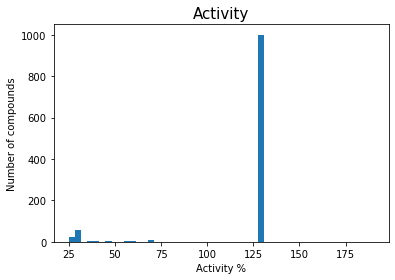

In [9]:
# The distribution of this particular subset is very unbalanced!
plt.hist(activ,bins=50)
plt.title("Activity",fontsize=15)
plt.xlabel("Activity %")
plt.ylabel("Number of compounds");

In [10]:
# Distribution of EC50 measurements

ec50 = [float(item) for item in sdfile[(sdfile["Activity_type"] == "EC50") & 
       (sdfile["Activity_units"] == "nM")]["Activity_value"].values]

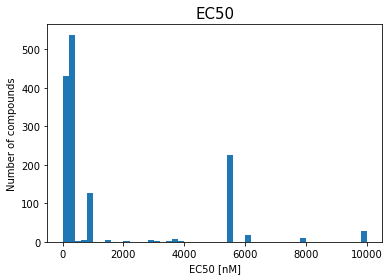

In [11]:
# This subset is also relatively unbalanced
plt.hist(ec50,bins=50)
plt.title("EC50",fontsize=15)
plt.xlabel("EC50 [nM]")
plt.ylabel("Number of compounds");

In [12]:
# Distribution of IC50 measurements

ic50 = [float(item) for item in sdfile[(sdfile["Activity_type"] == "IC50") & 
       (sdfile["Activity_units"] == "nM")]["Activity_value"].values]

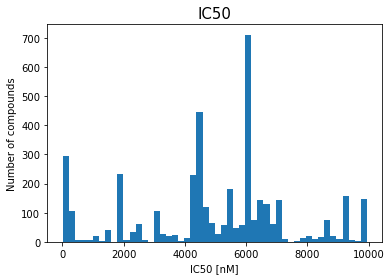

In [14]:
# This subset is reasonably large (4k compounds) and has a good coverage
# of the entire range of IC50 values. Hence it is suitable for dimensionality
# reduction and further analysis with GTM.
plt.hist(ic50,bins=50)
plt.title("IC50",fontsize=15)
plt.xlabel("IC50 [nM]")
plt.ylabel("Number of compounds");

In [15]:
# Distribution of "Inhibition" measurements

inhib = [float(item) for item in 
         sdfile[(sdfile["Activity_type"] == "Inhibition") & 
       (sdfile["Activity_units"] == "%")]["Activity_value"].values]

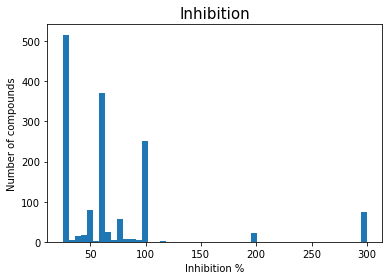

In [16]:
#Again, not a well distributed subset.
plt.hist(inhib,bins=50)
plt.title("Inhibition",fontsize=15)
plt.xlabel("Inhibition %")
plt.ylabel("Number of compounds");

<p style="text-align:justify">All the molecules, except for those with activity type of IC50 are dropped out. The remaining set of molecules is split into 5 classes, based on the value of IC50, and written into a SDFile, again, using the PandasTools rdkit module.</p>

In [17]:
# Dropping out all rows except for "IC50" with values in "nM"

sdfile = sdfile[(sdfile["Activity_type"] == "IC50") & 
       (sdfile["Activity_units"] == "nM")]

In [18]:
# Converting the "Activity_value" column into float numbers
sdfile["IC50"] = sdfile["Activity_value"].apply(float)

In [19]:
# Splitting the activity values into 5 classes
def splitter5(value,low=0,high=10000):
    
    h = (high-low)/5
    
    if low <= value < low+h:
        return 0
    elif low+h <= value < low+2*h:
        return 1
    elif low+2*h <= value < low+3*h:
        return 2
    elif low+3*h <= value < low+4*h:
        return 3
    else:
        return 4

In [20]:
sdfile["Class"] = sdfile["IC50"].apply(splitter5)

In [21]:
# Writing out the modified sd file
PandasTools.WriteSDF(sdfile,"Antivirals_IC50",molColName="Molecule")

Following these preprocessing steps, the SDF file was fed into the ISIDA Fragmentor software [2], which calculated a set of 238 ISIDA atom path descriptors for each molecule. The length of atom paths was set between 2 and 4 atoms long. For each molecule, the Fragmentor counts the occurence of every atom path. The results were saved into the libSVM (.svm) file, while the information on ISIDA fragment descriptors was saved into the header (.hdr) file.

#### Step 3: Reading in the ISIDA header file (for info on fragment descriptors)

In [22]:
# Header (.hdr) file - descriptor information
desc_info = pd.read_csv("Antivirals_IC50_IAB(2-4).hdr",
                        header=None,
                        delim_whitespace=True)
desc_info.drop(0,axis=1,inplace=True)
desc_info.rename(columns={1: "Fragment"});

In [23]:
print("Drag the integer slider to display the ISIDA fragment descriptors")
@widgets.interact(
    frag_index=widgets.IntSlider(min=0, max=len(desc_info)-1, step=1)
)
def frag_display(frag_index):
    print(desc_info.iloc[frag_index])

Drag the integer slider to display the ISIDA fragment descriptors


interactive(children=(IntSlider(value=0, description='frag_index', max=237), Output()), _dom_classes=('widget-…

#### Step 4: Reading in the ISIDA fragment file (in the .svm format)

Now we read the ISIDA fragment file and format it into a pandas DataFrame
object, where the rows represent molecules, and columns represent fragment
descriptor counts.

In [24]:
# ISIDA Fragment value file in the libsvm (.svm) format
isida_value = pd.read_csv("Antivirals_IC50_IAB(2-4).svm",
                          header=None,
                          delimiter="?")
isida_value.drop(0,axis=1,inplace=True)

In [25]:
# Creating an array of ISIDA fragment counts for each molecule
mol_frag_vector_array = []

# Looping through the list of molecules (the mol variable)
for mol in isida_value[1]:
    mol_frag_num_list = [int(index.split(":")[0]) for index in mol.split()]
    mol_frag_count_list = [int(index.split(":")[1]) for index in mol.split()]
    
    # ISIDA fragment vector (insert 0 if fragment NOT in mol_frag_num_list else insert 
    # the corresponding value from mol_frag_num_count)
    mol_frag_vector = []
    for num in range(1,len(desc_info)+1):
        if num in mol_frag_num_list:
            mol_frag_vector.append(mol_frag_count_list.pop(0))
        else:
            mol_frag_vector.append(0)
    
    mol_frag_vector_array.append(mol_frag_vector)

In [26]:
# Creating the DataFrame of ISIDA fragment counts for machine learning
data_isida = pd.DataFrame(data=mol_frag_vector_array,
                          columns=list(range(1,len(desc_info)+1)))
data_isida.head()

,1,2,3,4,5,6,7,8,9,10,...,229,230,231,232,233,234,235,236,237,238
0,1,1,1,1,1,3,7,2,4,3,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Finally, the data is ready for projection
# and visualization with GTM. We have 4k molecules and 238 descriptors.
data_isida.shape

(4000, 238)

## The GTM method - a brief overview


<p style="text-align:justify">The Generative Topographic Mapping (GTM) is a nonlinear dimensionality reduction method, developed by Bishop et al. [3], that aims to reconstruct a low-dimensional latent space representation of high-dimensional data as faithfully as possible.</p>

<p style="text-align:justify">In the GTM method, the dimensionality reduction problem is treated in a generative sense, i.e. the data in the high dimensional space $D$ is thought to arise from the latent space $L\in \mathbb{R^{2}}$ in a sequence of three steps:</p>

<p style="text-align:justify">$1.$ Given a prior probability distribution $p(\textbf{x})$, a point $\textbf{x}$ is randomly picked from the latent space. To make the GTM method comparable to SOM, the prior distribution over latent space is constrained to a set of delta functions centered on the nodes of a regular grid:</p>

$$ \tag{1}   
p(\textbf{x}) = \frac{1}{K}\sum_{i=1}^{K}\delta(\textbf{x}-\textbf{x}_{i})
$$  
    
<p style="text-align:justify">$2.$ Using a nonlinear transformation $\textbf{y}(\textbf{x};\textbf{W})$, the point $\textbf{x}$ is mapped from the latent space to the high dimensional manifold $y: L\in \mathbb{R^{2}}\to D$. In GTM, the mapping is done using a Radial Basis Function (RBF) neural network,</p>


$$ \tag{2}  
\textbf{y}(\textbf{x};\textbf{W}) = \textbf{W}\phi(\textbf{x})
$$

<p style="text-align:justify">where $\textbf{W}$ is a $D x M$ matrix of RBF weight coefficients and $\phi(\textbf{x})$ is a $M x 1$ vector of fixed radial basis functions $\phi_{j}(\textbf{x})$ in the latent space $L$. The mapping process is summarized in the Figure 1.</p>

<br>
<br>
<figure>
<img src="https://journals.plos.org/plosone/article/figure/image?size=medium&id=info:doi/10.1371/journal.pone.0129122.g001" alt="GTMMAP", style="height:300px">
<figcaption style="font-size:12px"><br><strong>Figure 1: </strong>The non-linear function $\textbf{y}(\textbf{r};\textbf{W}) = \textbf{W}\phi(\textbf{r})$ maps the data points from the low dimensional latent space $L$ to a smooth manifold in the high dimensional data space $D$.</figcaption>
</figure>    
<br>
<br>


<p style="text-align:justify">$3.$ Finally, a Gaussian noise assumption with inverse variance $\beta$ is made to correlate the point on the manifold with the original data point $t$. The entire generative process from step 1 to 3 can be thought of as sampling of a random variable $t$ from the Gaussian probability distribution</p>


$$ \tag{3}  
p(\textbf{t}|\textbf{W},\beta) = \frac{1}{K}\sum_{i=1}^{K}p(\textbf{t}|\textbf{x}_{i},\textbf{W},\beta) = \\ \frac{1}{K}\sum_{i=1}^{K}\left( \frac{\beta}{2\pi} \right)^{D/2}exp\left\{-\frac{\beta}{2}\parallel \textbf{y}(\textbf{x}_{i};\textbf{W})-\textbf{t} \parallel^{2} \right\} 
$$


<p style="text-align:justify">Summing the equation (3) over the entire dataset of $N$ examples, we obtain the <em>likelihood</em> function, which measures the probability with which the entire dataset is generated (sampled) from $t$. The logarithm of this function, also known as the <em>log likelihood</em>, is equal to:</p>


$$ \tag{4}
L(\textbf{W},\beta) = \sum_{n=1}^{N}ln\left\{ \frac{1}{K}\sum_{i=1}^{K}\left( \frac{\beta}{2\pi} \right)^{D/2}exp\left\{-\frac{\beta}{2}\parallel \textbf{y}(\textbf{x}_{i};\textbf{W})-\textbf{t} \parallel^{2} \right\}  \right\} 
$$


<p style="text-align:justify">The objective function $J$ of the GTM method consists of the <em>log likelihood</em> function (eq. 4), together with the regularization term, which controls the bias-variance tradeoff by restricting the accessible space of the weight matrix coefficients.</p>

$$ \tag{5}
J(\textbf{W},\beta, \lambda) = L(\textbf{W},\beta) - \frac{\lambda}{2}\sum_{j=1}^{M}\sum_{k=1}^{D}w_{jk}^{2}
$$

<p style="text-align:justify">The weight matrix $\textbf{W}$, inverse variance $\beta$, regularization coefficient $\lambda$, as well as the number of grid nodes $K$, number of RBF functions $M$ and the width of RBF functions $\sigma$, together constitute the parameters of the GTM method. After the random initialization of $\textbf{W}$ and $\beta$ and specifying the choice of other parameters, the objective function of GTM, $J$, is maximized with the Expectation Maximization (EM) [4] algorithm. After convergence of $J$ to the local maximum, the actual dimensionality reduction can be performed by computing the posterior probabilities or "responsibilities" $p(\textbf{x}_{i} | \textbf{t})$ of each grid node $i=1,...,K$ for every data point $n=1,...,N$:</p>


$$ \tag{6}
p(\textbf{x}_{i} | \textbf{t}) = \frac{p(\textbf{t} | \textbf{x}_{i},\textbf{W},\beta)p(\textbf{x}_{i})}{\sum_{i'=1}^{K}p(\textbf{t} | \textbf{x}_{i'},\textbf{W},\beta)p(\textbf{x}_{i'})} = \frac{exp\left\{-\frac{\beta}{2}\parallel \textbf{y}(\textbf{x}_{i};\textbf{W})-\textbf{t} \parallel^{2} \right\} }{\sum_{i'=1}^{K}exp\left\{-\frac{\beta}{2}\parallel \textbf{y}(\textbf{x}_{i'};\textbf{W})-\textbf{t} \parallel^{2} \right\} }
$$


<p style="text-align:justify">There are muliple ways of displaying the dataset in the latent space. One may either visualize the complete posterior distribution for each data point, or display the projected data points using the aggregate distribution metrics, such as the mean (eq.7) or the mode (eq.8) of posterior distribution:</p>


$$ \tag{7}
\left\langle \textbf{x} \right\rangle_{K}(\textbf{t}) = \sum_{i=1}^{K}\textbf{x}_{i}p(\textbf{x}_{i} | \textbf{t} )
$$

$$ \tag{8}
\textbf{x}^{max} = \arg\max_{i=1,...,K}p(\textbf{x}_{i} | \textbf{t} )
$$


#### Step 4: Dimensionality reduction and training a GTM classifier on ISIDA-encoded molecules

<p style="text-align:justify">We used the ugtm library [5] to project the molecules, encoded by ISIDA fragments, onto the 2D latent space. The length of ISIDA descriptors was rectricted from 2 to 4 atoms long. The initial dataset was normalized and split into the training and test sets for classification. The optimal choice of GTM parameters for dimensionality reduction was found using the GridSearchCV method of sklearn library [6].</p>

In [28]:
from ugtm import eGTC
from sklearn import datasets
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

In [29]:
# Splitting the data into  a training and test set

X = data_isida # fragment descriptors
y = sdfile["Class"] # Class labels

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

# preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [166]:
# GTM parameter optimization using the GridSearchCV technique

# Parameters to tune
tuned_params = {'regul': [0.0001, 0.001, 0.01], # Regularization coeff.
                's': [0.1, 0.2, 0.3], # RBF width (the sigma)
                'k': [16], # Number of GTM grid nodes
                'm': [4]} # Number of GTM RBF centers

# GTM classifier (GTC), bayesian
gs = GridSearchCV(eGTC(),
                  tuned_params,
                  cv=None,
                  scoring='accuracy',
                  n_jobs=-1,
                    verbose=4)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.4min finished


{'k': 16, 'm': 4, 'regul': 0.01, 's': 0.3}


In [30]:
# Predicting labels for X_test
gtc = eGTC(k=16,m=4,regul=0.01,s=0.1)
gtc = gtc.fit(X_train,y_train)
y_pred = gtc.predict(X_test)

In [31]:
# Print score

# Matthews correlation coefficient, values: 1 (perfect correlation),
# 0 (no correlation), -1 (opposite correlation between y_pred and y_true)

print(metrics.matthews_corrcoef(y_test,y_pred))

0.6679198919127055


In [32]:
# Classification report and confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       234
           1       0.47      0.35      0.40        94
           2       0.66      0.84      0.74       392
           3       0.91      0.85      0.88       435
           4       0.70      0.48      0.57       165

    accuracy                           0.75      1320
   macro avg       0.70      0.66      0.67      1320
weighted avg       0.76      0.75      0.75      1320



In [33]:
print(confusion_matrix(y_test,y_pred))

[[182   3  31   6  12]
 [ 15  33  38   4   4]
 [ 24  15 329  14  10]
 [  8   9  42 368   8]
 [  4  10  61  11  79]]


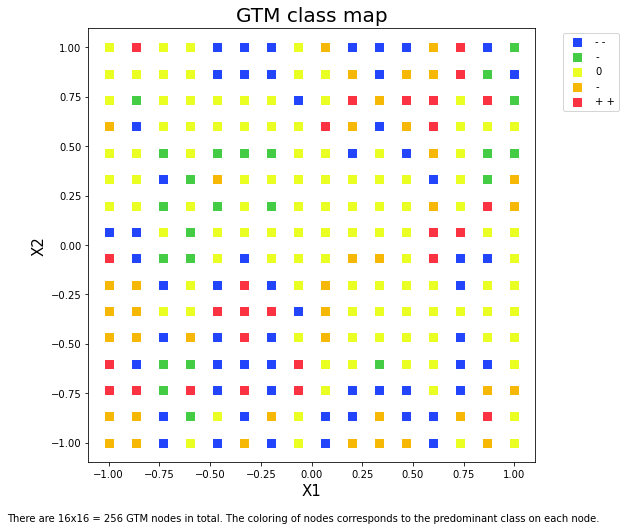

In [74]:
# Plotting the GTM class map for the training set

GTM_nodes = pd.DataFrame(gtc.optimizedModel.matX,columns=["X1","X2"])
GTM_nodes["predicted_node_label"] = gtc.node_label

fig,ax=plt.subplots(figsize=(8,8))
ax.set_title("GTM class map",fontsize=20)
ax.set_xlabel("X1",fontsize=15)
ax.set_ylabel("X2",fontsize=15)

ax.scatter(GTM_nodes[GTM_nodes["predicted_node_label"]==0]["X1"],
          GTM_nodes[GTM_nodes["predicted_node_label"]==0]["X2"],
          label="- -",
          color="#2244FA",
          marker="s",
          s=50)
ax.scatter(GTM_nodes[GTM_nodes["predicted_node_label"]==1]["X1"],
          GTM_nodes[GTM_nodes["predicted_node_label"]==1]["X2"],
          label="-",
          color="#44CC44",
          marker="s",
          s=50)
ax.scatter(GTM_nodes[GTM_nodes["predicted_node_label"]==2]["X1"],
          GTM_nodes[GTM_nodes["predicted_node_label"]==2]["X2"],
          label="0",
          color="#EAFF22",
          marker="s",
          s=50)
ax.scatter(GTM_nodes[GTM_nodes["predicted_node_label"]==3]["X1"],
          GTM_nodes[GTM_nodes["predicted_node_label"]==3]["X2"],
          label="-",
          color="#F7B705",
          marker="s",
          s=50)
ax.scatter(GTM_nodes[GTM_nodes["predicted_node_label"]==4]["X1"],
          GTM_nodes[GTM_nodes["predicted_node_label"]==4]["X2"],
          label="+ +",
          color="#FA3242",
          marker="s",
          s=50)

ax.legend(bbox_to_anchor=(1.2,1))

plt.text(x=-1.5,y=-1.4,s="There are 16x16 = 256 GTM nodes in total. The \
coloring of nodes corresponds to the predominant class on each node.");

In [53]:
from ugtm import eGTM
transformed = eGTM().fit(X_train).transform(X_test)

df = pd.DataFrame(transformed, columns=["x1", "x2"])

In [76]:
df["true class"] = y_test
df["predicted class"] = y_pred

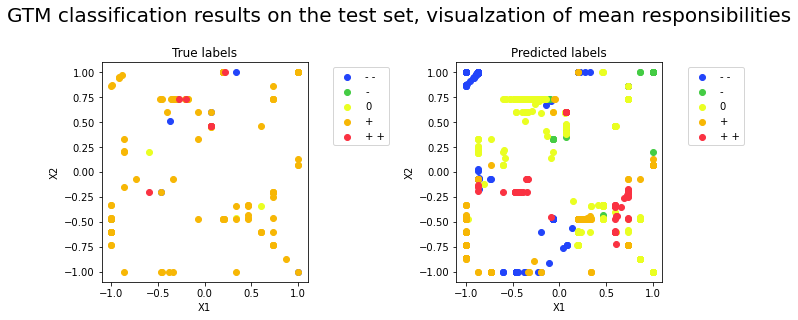

In [81]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
fig.suptitle("GTM classification results on the \
test set, visualzation of mean responsibilities",y=1.1,fontsize=20)

ax[0].scatter(df[df["true class"]==0]["x1"],
          df[df["true class"]==0]["x2"],
             label="- -",
             color="#2244FA")
ax[0].scatter(df[df["true class"]==1]["x1"],
          df[df["true class"]==1]["x2"],
             label="-",
             color="#44CC44")
ax[0].scatter(df[df["true class"]==2]["x1"],
          df[df["true class"]==2]["x2"],
             label="0",
             color="#EAFF22")
ax[0].scatter(df[df["true class"]==3]["x1"],
          df[df["true class"]==3]["x2"],
             label="+",
             color="#F7B705")
ax[0].scatter(df[df["true class"]==4]["x1"],
          df[df["true class"]==4]["x2"],
             label="+ +",
             color="#FA3242")
ax[0].set_title("True labels")
ax[0].legend()
ax[0].legend(bbox_to_anchor=(1.1,1))


ax[1].scatter(df[df["predicted class"]==0]["x1"],
          df[df["predicted class"]==0]["x2"],
             label="- -",
             color="#2244FA")
ax[1].scatter(df[df["predicted class"]==1]["x1"],
          df[df["predicted class"]==1]["x2"],
             label="-",
             color="#44CC44")
ax[1].scatter(df[df["predicted class"]==2]["x1"],
          df[df["predicted class"]==2]["x2"],
             label="0",
             color="#EAFF22")
ax[1].scatter(df[df["predicted class"]==3]["x1"],
          df[df["predicted class"]==3]["x2"],
             label="+",
             color="#F7B705")
ax[1].scatter(df[df["predicted class"]==4]["x1"],
          df[df["predicted class"]==4]["x2"],
             label="+ +",
             color="#FA3242")
ax[1].legend(bbox_to_anchor=(1.1,1))
ax[1].set_title("Predicted labels")

ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")

plt.tight_layout()

### References

[1] RDKit: Open-source cheminformatics; http://www.rdkit.org

[2] Ruggiu, F., Marcou, G., Varnek, A. and Horvath, D. (2010), ISIDA Property‐Labelled Fragment Descriptors. Mol. Inf., 29: 855-868. doi:10.1002/minf.201000099

[3] ”The Generative Topographic Mapping, Neural Computation 10, No. 1, 215–
234 (1998) 

[4] Dempster, A.P.; Laird, N.M.; Rubin, D.B. (1977). "Maximum Likelihood from Incomplete Data via the EM Algorithm". Journal of the Royal Statistical Society, Series B. 39 (1): 1–38.

[5] Gaspar, H.A., 2018. ugtm: A Python Package for Data Modeling and Visualization Using Generative Topographic Mapping. Journal of Open Research Software, 6(1), p.26. DOI: http://doi.org/10.5334/jors.235

[6]Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
